# Batch Normalization

In this notebook, you will implement the batch normalization layers of a neural network to increase its performance.  Please review the details of batch normalization from the lecture notes.

Utils has a solid API for building these modular frameworks and training them, and we will use this very well implemented framework as opposed to "reinventing the wheel."  This includes using the Solver, various utility functions, and the layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.

In [2]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Batchnorm forward pass

Implement the training time batchnorm forward pass, `batchnorm_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [4]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [-21.37058156   2.72669047 -11.98520168]
  stds:  [39.83212771 24.46814899 32.27850094]
After batch normalization (gamma=1, beta=0)
  mean:  [ 3.40005801e-16 -8.65973959e-17  3.88578059e-18]
  std:  [1.         0.99999999 1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [1.         1.99999998 2.99999999]


Implement the testing time batchnorm forward pass, `batchnorm_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [5]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in np.arange(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [ 0.01723153 -0.09139922 -0.03147149]
  stds:  [1.04633021 0.97816603 1.0387224 ]


## Batchnorm backward pass

Implement the backward pass for the batchnorm layer, `batchnorm_backward` in `nndl/layers.py`.  Check your implementation by running the following cell.

In [6]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda gamma: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda beta: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  8.000304822395571e-09
dgamma error:  3.8858182683547e-10
dbeta error:  3.2757500194219314e-12


## Implement a fully connected neural network with batchnorm layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate batchnorm layers.  You will need to modify the class in the following areas:

(1) The gammas and betas need to be initialized to 1's and 0's respectively in `__init__`.

(2) The `batchnorm_forward` layer needs to be inserted between each affine and relu layer (except in the output layer) in a forward pass computation in `loss`.  You may find it helpful to write an `affine_batchnorm_relu()` layer in `nndl/layer_utils.py` although this is not necessary.

(3) The `batchnorm_backward` layer has to be appropriately inserted when calculating gradients.

After you have done the appropriate modifications, check your implementation by running the following cell.

Note, while the relative error for W3 should be small, as we backprop gradients more, you may find the relative error increases.  Our relative error for W1 is on the order of 1e-4.

In [14]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              reg=reg, weight_scale=5e-2, dtype=np.float64,
                              use_batchnorm=True)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    if reg == 0: print('\n')

Running check with reg =  0
Initial loss:  2.2044929063241394
W1 relative error: 8.511312755084797e-06
W2 relative error: 2.045957721667931e-06
W3 relative error: 4.353681511339585e-10
b1 relative error: 6.661338147750939e-08
b2 relative error: 3.1086244689504383e-07
b3 relative error: 1.082974178674514e-10
beta1 relative error: 4.40792284736543e-09
beta2 relative error: 2.436088313138683e-09
gamma1 relative error: 4.457537372306341e-09
gamma2 relative error: 3.3656798904119674e-09


Running check with reg =  3.14
Initial loss:  6.694819311496509
W1 relative error: 0.2659467973768584
W2 relative error: 8.752509223124412e-06
W3 relative error: 8.40553711343653e-08
b1 relative error: 2.8421709430404007e-06
b2 relative error: 2.220446049250313e-07
b3 relative error: 4.3957755420588424e-10
beta1 relative error: 2.310731640668109e-07
beta2 relative error: 1.914143739184814e-08
gamma1 relative error: 3.698180942809976e-07
gamma2 relative error: 4.137476177934359e-08


## Training a deep fully connected network with batch normalization.

To see if batchnorm helps, let's train a deep neural network with and without batch normalization.

In [19]:
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.308247
(Epoch 0 / 10) train acc: 0.150000; val_acc: 0.130000
(Epoch 1 / 10) train acc: 0.223000; val_acc: 0.201000
(Epoch 2 / 10) train acc: 0.331000; val_acc: 0.257000
(Epoch 3 / 10) train acc: 0.404000; val_acc: 0.281000
(Epoch 4 / 10) train acc: 0.455000; val_acc: 0.315000
(Epoch 5 / 10) train acc: 0.493000; val_acc: 0.289000
(Epoch 6 / 10) train acc: 0.572000; val_acc: 0.316000
(Epoch 7 / 10) train acc: 0.619000; val_acc: 0.317000
(Epoch 8 / 10) train acc: 0.658000; val_acc: 0.318000
(Epoch 9 / 10) train acc: 0.694000; val_acc: 0.322000
(Epoch 10 / 10) train acc: 0.741000; val_acc: 0.318000
(Iteration 1 / 200) loss: 2.302408
(Epoch 0 / 10) train acc: 0.152000; val_acc: 0.159000
(Epoch 1 / 10) train acc: 0.214000; val_acc: 0.199000
(Epoch 2 / 10) train acc: 0.238000; val_acc: 0.193000
(Epoch 3 / 10) train acc: 0.289000; val_acc: 0.238000
(Epoch 4 / 10) train acc: 0.287000; val_acc: 0.236000
(Epoch 5 / 10) train acc: 0.367000; val_acc: 0.260000
(Epoch 6 / 

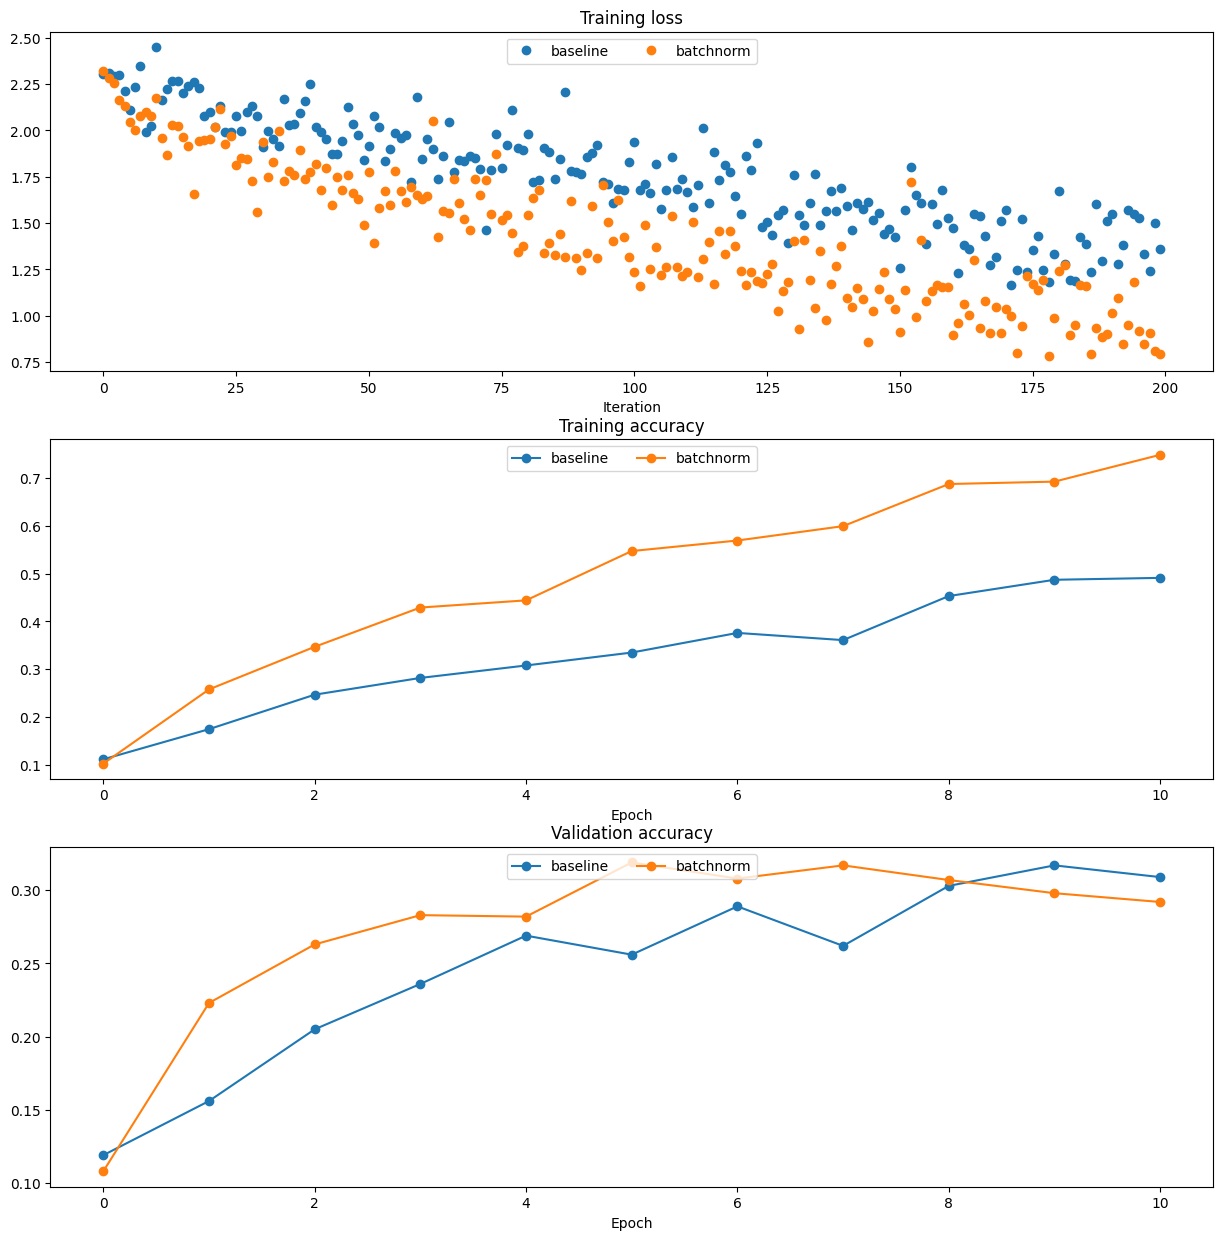

In [41]:
fig, axes = plt.subplots(3, 1)

ax = axes[0]
ax.set_title('Training loss')
ax.set_xlabel('Iteration')

ax = axes[1]
ax.set_title('Training accuracy')
ax.set_xlabel('Epoch')

ax = axes[2]
ax.set_title('Validation accuracy')
ax.set_xlabel('Epoch')

ax = axes[0]
ax.plot(solver.loss_history, 'o', label='baseline')
ax.plot(bn_solver.loss_history, 'o', label='batchnorm')

ax = axes[1]
ax.plot(solver.train_acc_history, '-o', label='baseline')
ax.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

ax = axes[2]
ax.plot(solver.val_acc_history, '-o', label='baseline')
ax.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
    ax = axes[i - 1]
    ax.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Batchnorm and initialization

The following cells run an experiment where for a deep network, the initialization is varied.  We do training for when batchnorm layers are and are not included.

In [42]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale {} / {}'.format(i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    bn_solver = Solver(bn_model, small_data,
                    num_epochs=10, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                    num_epochs=10, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    verbose=False, print_every=200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


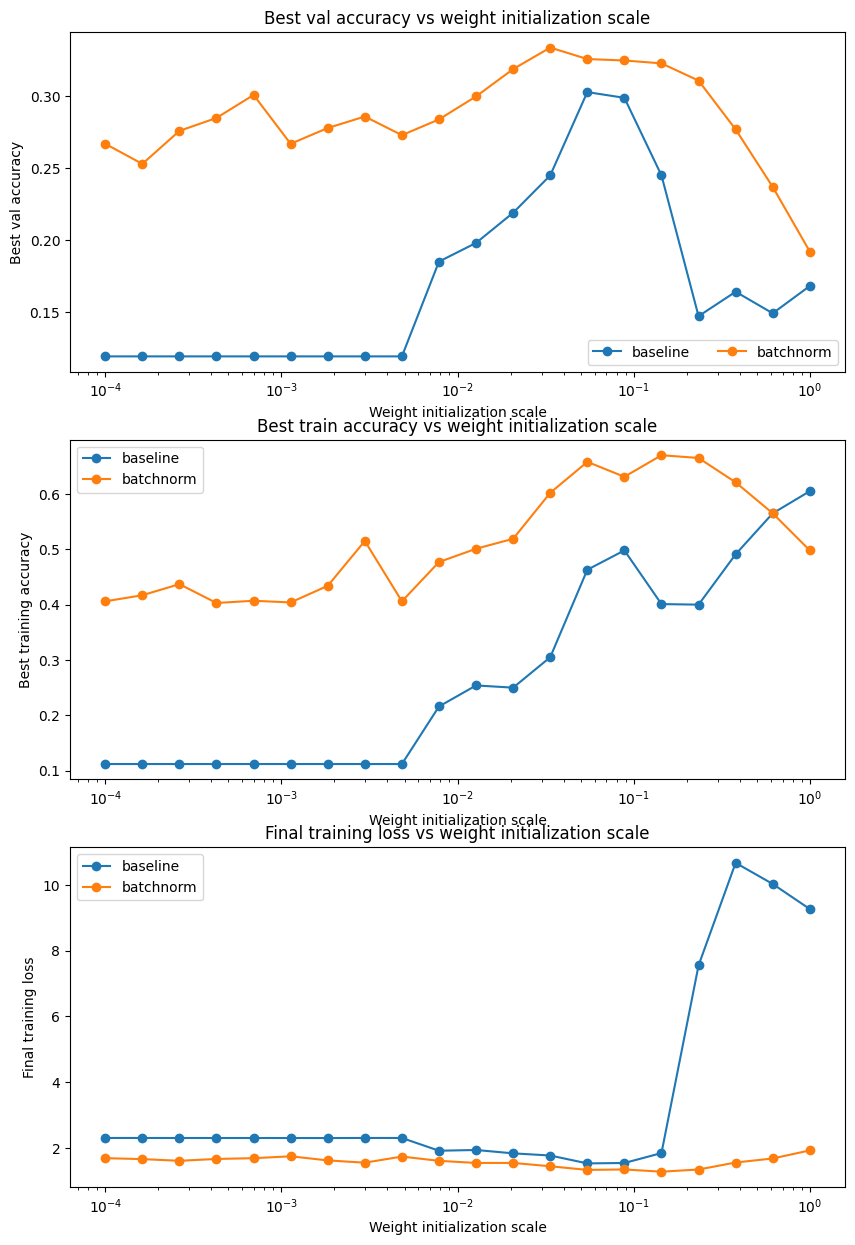

In [43]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
    
    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
    
    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

## Question:

In the cell below, summarize the findings of this experiment, and WHY these results make sense.

## Answer:


Findings: Compared to baseline, we can see that the training with Batchnorm has higher best val accuracy and best training accuracy while having the lower final training loss. Also, the training with Batchnorm is less sensitive to the weight initialization scale.

Why: This makes sense since the idea of Batchnorm is to make the output of each layer have unit statistics. 

In [44]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':

        # ================================================================ #
        # YOUR CODE HERE:
        #   A few steps here:
        #     (1) Calculate the running mean and variance of the minibatch.
        #     (2) Normalize the activations with the running mean and variance.
        #     (3) Scale and shift the normalized activations.  Store this
        #         as the variable 'out'
        #     (4) Store any variables you may need for the backward pass in
        #         the 'cache' variable.
        # ================================================================ #

        #calculate the sample_mean and sample_var
        sample_mean = np.mean(x, axis = 0)
        sample_var = np.var(x, axis = 0)

        #Calculate the running mean and variance of the minibatch
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var

        #Normalize the activations with the running mean and variance
        x_hat = (x - sample_mean) / (np.sqrt(sample_var + eps)) 
        #based on the unit activations function

        #Scale and shift the normalized activations
        out = gamma * x_hat + beta

        #Store any variables you may need for the backward pass
        cache = (sample_mean, sample_var, x, x_hat, gamma, eps)



        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the testing time normalized activation.  Normalize using
        #   the running mean and variance, and then scale and shift appropriately.
        #   Store the output as 'out'.
        # ================================================================ #

        out = gamma * ((x - running_mean) / (np.sqrt(running_var + eps))) + beta

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
    # ================================================================ #

    #First, we will get the params we need from cache
    sample_mean, sample_var, x, x_hat, gamma, eps = cache
    m = dout.shape[0]

    #Then, calculate the derivatives based on lecture slides
    dldx_hat = dout * gamma #derivative for x_hat
    
    #derivative for a(in slides)
    dlda = (1 / (np.sqrt(sample_var + eps))) * dldx_hat
    
    #derivative for mu
    dldmu = (-1 / np.sqrt(sample_var + eps)) * (np.sum(dldx_hat, axis = 0))
    
    #derivative for e(in slides)
    dlde = (-1 / 2) * (1 / ((sample_var + eps) ** 1.5)) * (x - sample_mean) * dldx_hat 
    
    dldvar = np.sum(dlde, axis = 0) #derivative for variance
    
    #derivative for x
    dx = dlda + ((2 * (x - sample_mean)) / m) * dldvar + (1 / m) * dldmu 

    dgamma = np.sum(dout * x_hat, axis = 0) #derivative for gamma
    dbeta = np.sum(dout, axis = 0) #derivate for beta

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return dx, dgamma, dbeta

In [ ]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=1, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - use_batchnorm: Whether or not the network should use batch normalization.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.use_batchnorm = use_batchnorm
        self.use_dropout = dropout < 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        # ================================================================ #
        # YOUR CODE HERE:
        #   Initialize all parameters of the network in the self.params dictionary.
        #   The weights and biases of layer 1 are W1 and b1; and in general the
        #   weights and biases of layer i are Wi and bi. The
        #   biases are initialized to zero and the weights are initialized
        #   so that each parameter has mean 0 and standard deviation weight_scale.
        #
        #   BATCHNORM: Initialize the gammas of each layer to 1 and the beta
        #   parameters to zero.  The gamma and beta parameters for layer 1 should
        #   be self.params['gamma1'] and self.params['beta1'].  For layer 2, they
        #   should be gamma2 and beta2, etc. Only use batchnorm if self.use_batchnorm
        #   is true and DO NOT do batch normalize the output scores.
        # ================================================================ #

        #we will Initialize them based on layers:
        for i in np.arange(1, self.num_layers + 1): #for all layers

            if i == 1: #for the layer 1

                self.params['b1'] = np.zeros(hidden_dims[i - 1]) #based on the size of the first hidden layer
                #the weights will have mean 0 and standard deviation weight_scale
                self.params['W1'] = np.random.normal(0, weight_scale, (input_dim, hidden_dims[i - 1]))

                #if the network uses batch normalization
                if self.use_batchnorm == True:
                    self.params['gamma1'] = np.ones(hidden_dims[i - 1]) #the gammas should be 1
                    self.params['beta1'] = np.zeros(hidden_dims[i - 1]) #the betas should be zero

            elif i == self.num_layers: #for the last layer

                #the size after the last layer will be the number of classes
                self.params['b' + str(i)] = np.zeros(num_classes)
                self.params['W' + str(i)] = np.random.normal(0, weight_scale, (hidden_dims[i - 2], num_classes))

            else: #for the layer except the first and the last

                #based on the size of the ith hidden layer
                self.params['b' + str(i)] = np.zeros(hidden_dims[i - 1])
                self.params['W' + str(i)] = np.random.normal(0, weight_scale, (hidden_dims[i - 2], hidden_dims[i - 1]))

                #if the network uses batch normalization
                if self.use_batchnorm == True:
                    self.params['gamma' + str(i)] = np.ones(hidden_dims[i - 1]) #the gammas should be 1
                    self.params['beta' + str(i)] = np.zeros(hidden_dims[i - 1]) #the betas should be zero

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
        if seed is not None:
            self.dropout_param['seed'] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.use_batchnorm:
            self.bn_params = [{'mode': 'train'} for i in np.arange(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.dropout_param is not None:
            self.dropout_param['mode'] = mode
        if self.use_batchnorm:
            for bn_param in self.bn_params:
                bn_param['mode'] = mode

        scores = None

        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the forward pass of the FC net and store the output
        #   scores as the variable "scores".
        #
        #   BATCHNORM: If self.use_batchnorm is true, insert a bathnorm layer
        #   between the affine_forward and relu_forward layers.  You may
        #   also write an affine_batchnorm_relu() function in layer_utils.py.
        #
        #   DROPOUT: If dropout is non-zero, insert a dropout layer after
        #   every ReLU layer.
        # ================================================================ #

        out_list = []
        cache_list = []
        dropcache_list = []
        X = X.reshape([X.shape[0], -1])

        for i in np.arange (1, self.num_layers + 1):

            #we will consider three instances:

            if i == 1: #for the layer 1

                #if the network uses batch normalization
                if self.use_batchnorm:
                    #affine -> batchnorm -> relu
                    out1, cache1 = affine_batchnorm_relu_forward(X, self.params['W' + str(i)], self.params['b' + str(i)],
                                        self.params['gamma' + str(i)], self.params['beta' + str(i)], self.bn_params[i - 1])

                else:
                    #affine -> relu
                    out1, cache1 = affine_relu_forward(X, self.params['W' + str(i)], self.params['b1'])

                cache_list.append(cache1)

                #If dropout is non-zero
                if self.use_dropout:

                    #insert a dropout after ReLU layer
                    out1, cached = dropout_forward(out1, self.dropout_param)
                    dropcache_list.append(cached)

                out_list.append(out1)


            elif i == self.num_layers: #for the last layer

                #do the last layer affine forward
                scores, cachescores = affine_forward(out_list[i - 2], self.params['W' + str(i)], self.params['b' + str(i)])

                cache_list.append(cachescores)

            else: #for the layers except the first and the last

                #if the network uses batch normalization
                if self.use_batchnorm:
                    #affine -> batchnorm -> relu
                    outnow, cachenow = affine_batchnorm_relu_forward(out_list[i - 2], self.params['W' + str(i)], self.params['b' + str(i)],
                                                        self.params['gamma' + str(i)], self.params['beta' + str(i)], self.bn_params[i - 1])

                else:
                    #affine -> relu
                    outnow, cachenow = affine_relu_forward(out_list[i - 2], self.params['W' + str(i)], self.params['b' + str(i)])

                cache_list.append(cachenow)

                #If dropout is non-zero
                if self.use_dropout:

                    #insert a dropout after ReLU layer
                    outnow, cached = dropout_forward(outnow, self.dropout_param)
                    dropcache_list.append(cached)

                out_list.append(outnow)

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the backwards pass of the FC net and store the gradients
        #   in the grads dict, so that grads[k] is the gradient of self.params[k]
        #   Be sure your L2 regularization includes a 0.5 factor.
        #
        #   BATCHNORM: Incorporate the backward pass of the batchnorm.
        #
        #   DROPOUT: Incorporate the backward pass of dropout.
        # ================================================================ #

        loss, dx = softmax_loss(scores, y) #calculate loss and dx by given softmax_loss

        for j in np.arange (self.num_layers, 0, -1): #loop from the last layer to the first layer
            #L2 regularization by multiplying the regularization loss by 0.5(with factor reg)
            loss += (self.reg) * (np.sum(self.params['W' + str(j)] ** 2)) * 0.5                                                                

            if j == self.num_layers: #from the last layer
                #backward affine of the second layer
                currentdx, grads['W' + str(j)], grads['b' + str(j)] = affine_backward(dx, cache_list[j - 1])

            else: #for other layers:

                #If dropout is non-zero
                if self.use_dropout:
                    currentdx = dropout_backward(currentdx, dropcache_list[j - 1])

                #if the network uses batch normalization
                if self.use_batchnorm:
                    currentdx, grads['W' + str(j)], grads['b' + str(j)], grads['gamma' + str(j)], grads['beta' + str(j)] = affine_batchnorm_relu_backward(currentdx, cache_list[j - 1])

                else:
                    currentdx, grads['W' + str(j)], grads['b' + str(j)] = affine_relu_backward(currentdx, cache_list[j - 1])

            #update the gradients of W
            grads['W' + str(j)] += (self.reg) * self.params['W' + str(j)]

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

        return loss, grads